In [ ]:
%load_ext autoreload
%autoreload 2
!git clone https://github.com/osmanio2/modular-bert-dst.git
import sys
root = '/content/modular-bert-dst'
sys.path.append(root)
!gdown https://drive.google.com/uc?id=1-6vYegAJyMd5O9qXccl_cnUAMXspldj8 -O {root}/data/train/dailogues.json
!{sys.executable} -m pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!{sys.executable} -m pip install transformers==2.10
import time
import sys
import os
import torch as T
import numpy as np
import transformers as tf
import intent_data as D
from collections import defaultdict
import argparse
import pickle

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 665kB 4.7MB/s 
     |████████████████████████████████| 890kB 19.8MB/s 
     |████████████████████████████████| 1.1MB 29.6MB/s 
     |████████████████████████████████| 3.8MB 47.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=abc7e0d6fc3ccc0a07d616db7c29f8c60fda1601e27ae06dae112bdb32fe499b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a5012363

In [ ]:
class Run:
    def __init__(self):
        self.records = defaultdict(list)
        
    def log(self, key, value):
        self.records[key].append(value)


def evaluate(model, batch):
    token_type_ids = batch.x.token_type_ids
    scores = model(batch.x.input_ids, batch.x.attention_mask, batch.x.token_type_ids)[0]
    mask = batch.x.attention_mask[..., 0] # B.C
    scores = scores + (mask.float() - 1) * 1e8
    loss = T.nn.functional.cross_entropy(scores, batch.y)
    return scores, loss

def metrics(scores, labels):
    with T.no_grad():
        preds = T.max(scores, dim=-1)[1] == labels
        correct = T.where(preds == True)[0]
        wrong = T.where(preds == False)[0]
        return correct.shape[0]/scores.shape[0], correct.cpu().numpy(), wrong.cpu().numpy()
    
def print_example(tokenizer, batch, idx, scores, correct):
    with T.no_grad():
        ids, token_type_ids, mask = batch.x.input_ids[idx], batch.x.token_type_ids[idx], batch.x.attention_mask[idx, :, 0]
        scores = scores[idx]
        state = ('Correct' if correct else 'Wrong')
        print(' '.join(tokenizer.convert_ids_to_tokens(ids[0, token_type_ids[0] == 0], skip_special_tokens=True)))
        total = int(mask.sum())
        print('\t'.join([' '.join(tokenizer.convert_ids_to_tokens(ids[i, token_type_ids[i] == 1],
                                                                  skip_special_tokens=True))
                         + ': {:.2f}'.format(T.softmax(scores, dim=0)[i])
                         for i in range(total)] + [state]))

def train(model, optim, train_data, valid_data, no_batches, valid_duration=100,
          cuda=True, verbose=False, tokenizer=None, max_grad_norm=1.0,
          valid_size=1, run=None, batch_size=1, no_examples=10):
    if cuda:
        model = model.cuda()
    optim, scheduler = optim
    print("About to start training")
    start_time = time.time()
    valid_loss, valid_acc, max_acc = 0, 0, 0
    print_gpu = False
    batch_size, total_batch_size = batch_size
    no_iter = total_batch_size//batch_size
    i = 0
    while True:
        optim.zero_grad()
        scores, loss, acc = 0, 0, 0
        for k in range(no_iter):
            batch = next(train_data)
            scores_, loss_ = evaluate(model, batch)
            scores += scores_/no_iter
            loss_ /= no_iter
            loss_.backward()
            loss += loss_
            acc_, _, _ = metrics(scores_ , batch.y)
            acc += acc_/no_iter
        if max_grad_norm > 0:
            T.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        loss = float(loss)
        optim.step()
        scheduler.step()
        
        if  i % valid_duration == 0:
            model.eval()
            valid_acc, valid_loss = 0, 0
            with T.no_grad():
                if verbose:
                    print("##################################################################################")
                for k in range(valid_size):
                    batch = next(valid_data)
                    valid_scores, valid_los = evaluate(model, batch)
                    v_acc,  corr_ids, wrong_ids, = metrics(valid_scores, batch.y)
                    valid_loss += float(valid_los)
                    valid_acc += v_acc
                    if verbose and k < no_examples:
                        if len(corr_ids) > 0:
                            idx = np.random.choice(corr_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=True)
                            print("-----------------------------------------------------------------------------")
                        if len(wrong_ids) > 0:
                            idx = np.random.choice(wrong_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=False)
                            print("-----------------------------------------------------------------------------")
                if verbose:
                    print("##################################################################################")
                valid_loss /= valid_size
                valid_acc /= valid_size
                if valid_acc > max_acc:
                    max_acc = valid_acc
                    model.save_model()        
            model.train()
        
        if print_gpu:
            print(nvgpu.gpu_info())
            print_gpu = False
        if run:
            run.log("train_loss", loss)
            run.log("train_acc", acc)
            run.log("valid_loss", valid_loss)
            run.log("valid_acc", valid_acc)
            run.log("batch", i)
        sys.stderr.write(f'\rtrain loss: {loss:.2f}\ttrain acc {acc:.2f}\t' + 
                         f'valid loss: {valid_loss:.2f}\tvalid acc {valid_acc:.2f}' +
                         f'\tbatch: {i}\ttime: {time.time()-start_time:.2f}{"": <30}')
        i += 1
        if i >= no_batches - 1:
            break
    return model

def _in(n, trainable_parameters):
    return any(nd in n for nd in trainable_parameters)

def get_model(name, trainable_parameters=None):
    model_name = name.split('-')[0].capitalize()
    tokenizer = getattr(tf, f'{model_name}Tokenizer').from_pretrained(name)
    model = getattr(tf, f'{model_name}ForMultipleChoice').from_pretrained(name,
                                                                                  num_labels=4)
    if trainable_parameters is not None:
        for name, param in model.named_parameters():
            if not _in(name, trainable_parameters):
                param.requires_grad = False
    return tokenizer, model


class AdapterLayer(T.nn.Module):
    
    def __init__(self, input_size, dropout, hidden_size=64, init_scale=1e-3, act='gelu'):
        super().__init__()
        self.act = getattr(T.nn.functional, act)
        self.squeeze = T.nn.Linear(input_size, hidden_size)
        self.squeeze.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.squeeze.bias.data)
        self.expand = T.nn.Linear(hidden_size, input_size)
        self.expand.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.expand.bias.data)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.dropout(x)
        return self.expand(self.act(self.squeeze(x))) + x
    

def add_adapter_layers(model, **kwargs):
    input_size = model.config.hidden_size
    layers = model.bert.encoder.layer
    for layer in layers:
        adapter1 = AdapterLayer(input_size, layer.attention.output.dropout, **kwargs)
        adapter2 = AdapterLayer(input_size, layer.output.dropout, **kwargs)
        layer.attention.output.add_module('dropout', adapter1)
        layer.output.add_module('dropout', adapter2)
    return model


def save_model(model, trainable_parameters, url):
    with open(url, 'wb') as f:
        params_to_save = {k: v.detach().cpu() for k, v in model.state_dict().items()
                          if _in(k, trainable_parameters)}
        pickle.dump(params_to_save, f)


def load_model(model, url):
    with open(url, 'rb') as f:
        return model.load_state_dict(pickle.load(f), False)


def main(args):
    
    data_dir = args.data_url
    trainable_parameters = (args.trainable_parameters.split(' ') if args.trainable_parameters != '' 
                                                                 else None)
    
    print("data directory is: " + data_dir)
    # Load the model
    tokenizer, model = get_model(args.model_name, trainable_parameters)
    # Load the data
    train_itr = D.IntentDataset(os.path.join(data_dir,'train'), tokenizer, # pos_prob=args.pos_prob,
                            max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                             shuffle=True, pin_memory=True,
                                                             cuda=True, loop=True, drop_last=True)
    valid_itr = D.IntentDataset(os.path.join(data_dir,'dev'), tokenizer, # pos_prob=1.0, 
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True, pin_memory=True,
                                                               cuda=True, loop=True, drop_last=True)
    # Train only adapter layers
    model = add_adapter_layers(model, hidden_size=args.adapter_size)
    if args.checkpoint:
        model.load_state_dict(pickle.load(open(os.path.join(data_dir, args.checkpoint), 'rb')), False)
    # Parallise if required
    if T.cuda.device_count() > 1:
        print("Let's use", T.cuda.device_count(), "GPUs!")
        model = T.nn.DataParallel(model)    
    # Create the optimizer
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and not _in(n, no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and _in(n, no_decay)],
            "weight_decay": 0.0
        },
    ]
    if args.model_url is not None:
        save_fn = lambda : save_model(model, trainable_parameters, 
                                      os.path.join(data_dir, args.model_url))
    else:
        save_fn = type(None)
    setattr(model, 'save_model', save_fn)
    optimizer = tf.AdamW(optimizer_grouped_parameters, lr=args.lr, eps=1e-8)
    scheduler = tf.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1*args.num_batches), num_training_steps=args.num_batches
    )
    
    optim = [optimizer, scheduler]
    run = Run()
    model = train(model, optim, train_itr, valid_itr, args.num_batches, args.valid_duration,
                  verbose=args.verbose, tokenizer=tokenizer, max_grad_norm=args.max_grad_norm,
                  valid_size=args.valid_size, run=run, cuda=True,
                  batch_size=[args.batch_size, args.total_batch_size])
    return model, run

In [ ]:
# get command-line arguments
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='bert-base-uncased')
parser.add_argument('--trainable_parameters', type=str, help='space separated parameters to train',
                    default=' '.join(trainable_parameters))
parser.add_argument('--total_batch_size', type=int, default=64, help='The total batch size')
parser.add_argument('--batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--num_batches', type=int, default=1000, help='number of batches to train')
parser.add_argument('--max_len', type=int, default=120, help='Maximum length of the context')
parser.add_argument('--adapter_size', type=int, default=256, help='hidden size of the adapter layers')
parser.add_argument('--data_url', type=str, help='data directory')
parser.add_argument('--pos_prob', type=float, default=0.5, help='Probability of sampling positive examples')
parser.add_argument('--optim', type=str, default='Adam', help='data directory')
parser.add_argument('--lr', type=float, default=6e-5, help='Learning rate')
parser.add_argument('--amsgrad', type=bool, default=False, help=' whether to use the AMSGrad variant')
parser.add_argument('--weight_decay', type=float, default=0.006, help='L2 Regularization weight decay')
parser.add_argument('--max_grad_norm', default=1.0, type=float, help="Max gradient norm.")
parser.add_argument('--valid_duration', type=int, default=100, help='The number of batches before validating')
parser.add_argument('--verbose', type=bool, default=True, help='Show Live valid examples with prediction during validating')
parser.add_argument('--valid_size', type=int, default=50, help='The number of valid batches to evaluate')
parser.add_argument('--model_url', type=str, default='model.pkl', help='URL to save the model')
parser.add_argument('--checkpoint', type=str, help='Start training from a checkpoint')

args = parser.parse_args(['--data_url', root, '--adapter_size', '256', '--checkpoint', 'model_intent.pkl',
                          '--batch_size', '10', '--total_batch_size', '30', '--num_batches', '10000',
                            '--model_url', 'model_intent.pkl', 
                            ])
model, run = main(args)

data directory is: drive/dialog-data/
About to start training


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


##################################################################################
system : ace hotel london is a 4 star hotel in the area . user : do you have a contact number ? service description : accommodation searching and booking portal
none of the intentions are active: 0.00	reserve rooms at a selected place for given dates: 0.00	look for accommodation in a city of choice previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : the phone number is 40 ##8 - 298 - 65 ##33 . user : are there vegetarian options in the restaurant ? and do they have outdoor seating ? service description : a popular restaurant search and reservation service
none of the intentions are active: 0.00	make a table reservation at a restaurant: 0.00	find restaurants by location and by category previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : i found 10 places for you

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
train loss: 0.05	train acc 0.97	valid loss: 0.07	valid acc 0.98	batch: 99	time: 482.59                              

##################################################################################
system : is there anything else i can help you with ? user : not at this time . i appreciate your help . service description : a popular service for searching and res ##erving rooms in hotels
none of the intentions are active: 1.00	reserve a selected hotel for given dates: 0.00	find a hotel at a given location previous user intention: 0.00	Correct
-----------------------------------------------------------------------------
system : bryan adams is well liked . the activity begins at 8 : 30 pm , march 2nd , at the theater of the clouds . user : where is the location for the activity ? service description : the comprehensive portal to find and reserve seats at events near you
none of the intentions are active: 0.00	find events in a given city previous user intention: 1.00	buy tickets for an event: 0.00	Correct
-----------------------------------------------------------------------------
system : 4000 ##1 f

train loss: 0.19	train acc 0.93	valid loss: 0.06	valid acc 0.98	batch: 199	time: 968.19                              

##################################################################################
system : how about a historical landmark called 30 st mary axe ( the g ##her ##kin ) ? user : sure , could you help me search for songs now ? service description : a popular provider of a wide range of music content for searching and listening
none of the intentions are active: 0.00	search for a song: 0.97	play the selected song on the device: 0.03	Correct
-----------------------------------------------------------------------------
system : what day ? how many tickets ? user : i need 2 tickets for next monday . service description : the comprehensive portal to find and reserve seats at events near you
none of the intentions are active: 0.00	find events in a given city: 0.00	buy tickets for an event previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : it is pop user : thanks a lot service description : a popular provider of a wide ra

train loss: 0.06	train acc 0.97	valid loss: 0.07	valid acc 0.98	batch: 299	time: 1457.95                              

##################################################################################
system : how about the one departing 8 : 30 am , it has 1 transfer and costs $ 65 ? user : what is my goal station and where will i depart from ? service description : book bus journeys from the biggest bus network in the country
none of the intentions are active: 0.00	find a bus journey for a given pair of cities previous user intention: 1.00	buy tickets for a bus journey: 0.00	Correct
-----------------------------------------------------------------------------
system : to confirm , you want to play small town boy on the tv . user : yes , that would be perfect . service description : a popular provider of a wide range of music content for searching and listening
none of the intentions are active: 0.00	search for a song: 0.00	play the selected song on the device previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : sure , can i get s

train loss: 0.05	train acc 0.97	valid loss: 0.06	valid acc 0.98	batch: 399	time: 1964.67                              

##################################################################################
system : how about how to train your dragon : the hidden world , rated 7 . 7 ? user : sure . could you find me a rock star ? prefer ##ably something by stars ##et from ' 14 ? service description : a popular provider of a wide range of music content for searching and listening
none of the intentions are active: 0.00	search for a song: 0.99	play the selected song on the device: 0.01	Correct
-----------------------------------------------------------------------------
system : okay your reservation is confirmed . enjoy your event ! user : no thank you that ' s all i need . service description : the comprehensive portal to find and reserve seats at events near you
none of the intentions are active: 0.04	find events in a given city: 0.00	buy tickets for an event previous user intention: 0.96	Correct
-----------------------------------------------------------------------------
system : the first apartment out 

train loss: 0.11	train acc 0.97	valid loss: 0.04	valid acc 0.99	batch: 499	time: 2453.84                              

##################################################################################
system : the alarm has been added . user : thanks , that ' s all . service description : manage alarms by getting and setting them easily
none of the intentions are active: 0.00	get the alarms user has already set: 0.02	set a new alarm previous user intention: 0.97	Correct
-----------------------------------------------------------------------------
system : the address is 123 - 01 roosevelt avenue . user : okay , that sounds like something i may be interested i . service description : the comprehensive portal to find and reserve seats at events near you
none of the intentions are active: 0.00	find events in a given city previous user intention: 1.00	buy tickets for an event: 0.00	Correct
-----------------------------------------------------------------------------
system : i don ' t think children would enjoy this venue , and it is not free . user : okay , cool . that ' s all i need for now , bye . serv

train loss: 0.27	train acc 0.97	valid loss: 0.06	valid acc 0.99	batch: 599	time: 2940.30                              

##################################################################################
system : what genre do you like ? user : i ' m in the mood for a comic show . service description : the wide ##st selection and lowest prices for movie rental ##s
none of the intentions are active: 0.00	find movies to watch by genre and , optional ##ly , director or actors previous user intention: 1.00	rent a movie to watch , with optional sub ##titles: 0.00	Correct
-----------------------------------------------------------------------------
system : hello , how can i help ? user : will you find a one way flight ? service description : find one way and round trip flights to your favorite city
none of the intentions are active: 0.00	search for one - way flights to the destination of choice: 0.87	search for round - trip flights to the destination of choice: 0.13	Correct
-----------------------------------------------------------------------------
system : sure . please can you confirm me that you wish to 

train loss: 0.03	train acc 1.00	valid loss: 0.09	valid acc 0.97	batch: 699	time: 3426.81                              

##################################################################################
system : there are 5 available cars , one of which is a standard civic available from seattle - tacoma international airport on march 11th . user : how much will this set me back ? service description : car rental service with extensive coverage of locations and cars
none of the intentions are active: 0.00	search for available rental cars by city and date previous user intention: 1.00	reserve car rental for given dates and location: 0.00	Correct
-----------------------------------------------------------------------------
system : sorry , they don ' t have out door seating and they are reach ##able at 88 ##8 - 78 ##6 - 79 ##19 . user : okay , thanks much . please can you help me to find a table there ? service description : a popular restaurant search and reservation service
none of the intentions are active: 0.00	make a table reservation at a restaurant: 0.20	find restaurants by location and by category

train loss: 0.01	train acc 1.00	valid loss: 0.05	valid acc 0.98	batch: 799	time: 3914.22                              

##################################################################################
system : i found 8 buses for you . what about departing time 7 : 40 am with 1 transfer for $ 66 user : that ' s perfect service description : book bus journeys from the biggest bus network in the country
none of the intentions are active: 0.00	find a bus journey for a given pair of cities previous user intention: 1.00	buy tickets for a bus journey: 0.00	Correct
-----------------------------------------------------------------------------
system : shall i book the car ? user : yes . but it can be done later . service description : car rental service with extensive coverage of locations and cars
none of the intentions are active: 0.99	search for available rental cars by city and date previous user intention: 0.00	reserve car rental for given dates and location: 0.01	Correct
-----------------------------------------------------------------------------
system : i found 10 hotels that match your search . how 

train loss: 0.05	train acc 0.97	valid loss: 0.08	valid acc 0.98	batch: 899	time: 4401.62                              

##################################################################################
system : the temperature will be 75 degree fa ##hre ##nh ##eit and 20 % chance of rain . user : what about the windy ? service description : check the weather for any place and any date
none of the intentions are active: 0.00	get the weather of a certain location on a date previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : it is + 1 215 - 37 ##2 - 900 ##0 user : check in tomorrow service description : accommodation searching and booking portal
none of the intentions are active: 0.00	reserve rooms at a selected place for given dates: 0.42	look for accommodation in a city of choice previous user intention: 0.58	Wrong
-----------------------------------------------------------------------------
system : anything else today ? user : no , that is all . service description : check the weather for any place and any date
none of the intent

train loss: 0.05	train acc 1.00	valid loss: 0.08	valid acc 0.98	batch: 999	time: 4888.64                              

##################################################################################
system : do you need more help ? user : no , not right now . thanks . service description : car rental service with extensive coverage of locations and cars
none of the intentions are active: 1.00	search for available rental cars by city and date: 0.00	reserve car rental for given dates and location previous user intention: 0.00	Correct
-----------------------------------------------------------------------------
system : would you like to view the property ? user : that would be great , on the 13th of this month . service description : a widely used service for finding apartments and scheduling visits
none of the intentions are active: 0.00	find an apartment in a city for a given number of bedrooms previous user intention: 0.00	schedule a visit for a given property on a particular date: 1.00	Correct
-----------------------------------------------------------------------------
system : i located 3 of the

train loss: 0.03	train acc 0.97	valid loss: 0.07	valid acc 0.98	batch: 1099	time: 5375.63                              

##################################################################################
system : where are you leaving from ? are you leaving on march 2nd ? user : i want to leave on the 1st . find me an economy ticket to mexico city . service description : find one way and round trip flights to your favorite city
none of the intentions are active: 0.00	search for one - way flights to the destination of choice previous user intention: 0.94	search for round - trip flights to the destination of choice: 0.06	Correct
-----------------------------------------------------------------------------
system : alam ##eda children ' s specialized is a psychologist located in oakland . user : can you tell me the contact number and address of the office ? service description : discover the right therapist for you and make reservations easily
none of the intentions are active: 0.00	make a reservation with the therapist based on user ' s wish: 0.00	discover therapist according to user ' s conditions previou

train loss: 0.05	train acc 0.97	valid loss: 0.04	valid acc 0.99	batch: 1199	time: 5863.02                              

##################################################################################
system : confirm me please . you want to schedule a visit to casa pin ##o condo ##s on march 4th ? user : no . make it please on 3rd of this month . service description : a widely used service for finding apartments and scheduling visits
none of the intentions are active: 0.00	find an apartment in a city for a given number of bedrooms: 0.00	schedule a visit for a given property on a particular date previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : hello , how can i help ? user : i am interested in finding an apartment with two bedrooms in san jose . service description : a widely used service for finding apartments and scheduling visits
none of the intentions are active: 0.00	find an apartment in a city for a given number of bedrooms: 1.00	schedule a visit for a given property on a particular date: 0.00	Correct
-------------------

train loss: 0.04	train acc 0.97	valid loss: 0.06	valid acc 0.98	batch: 1299	time: 6350.04                              

##################################################################################
system : this will cost you $ 57 in total . user : are there any alternatives which i can pick up at 1 : 30 pm ? service description : car rental service with extensive coverage of locations and cars
none of the intentions are active: 0.00	search for available rental cars by city and date previous user intention: 1.00	reserve car rental for given dates and location: 0.00	Correct
-----------------------------------------------------------------------------
system : it is $ 58 in total . user : okay , that ' s good . i also need to look for an apartment there . service description : a widely used service for finding apartments and scheduling visits
none of the intentions are active: 0.00	find an apartment in a city for a given number of bedrooms: 1.00	schedule a visit for a given property on a particular date: 0.00	Correct
-----------------------------------------------------------------------------
system

train loss: 0.20	train acc 0.97	valid loss: 0.05	valid acc 0.98	batch: 1399	time: 6836.92                              

##################################################################################
system : for how long ? user : one room , 5 days . service description : accommodation searching and booking portal
none of the intentions are active: 0.00	reserve rooms at a selected place for given dates previous user intention: 1.00	look for accommodation in a city of choice: 0.00	Correct
-----------------------------------------------------------------------------
system : hello , how can i help ? user : i want to know how the weather will be in san diego on march 6th . service description : check the weather for any place and any date
none of the intentions are active: 0.00	get the weather of a certain location on a date: 1.00	Correct
-----------------------------------------------------------------------------
system : sure , their phone number is 415 - 77 ##5 - 76 ##44 user : thank you very much for your help , that ' s all i need . service description : a popular restaurant search and reservation

train loss: 0.06	train acc 0.97	valid loss: 0.08	valid acc 0.97	batch: 1499	time: 7323.95                              

##################################################################################
system : no worries , anything else ? user : nah , that ' s all thanks . service description : on - demand taxi calling service
none of the intentions are active: 1.00	call a taxi to head to a given destination previous user intention: 0.00	Correct
-----------------------------------------------------------------------------
system : the average temperature is 70 degrees with a 23 percent chance of rain . user : what is the humidity going to be ? service description : check the weather for any place and any date
none of the intentions are active: 0.00	get the weather of a certain location on a date previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : your ticket is all set . user : can you also look for hotels in that area ? service description : accommodation searching and booking portal
none of the intentions are active: 0.00	reser

train loss: 0.03	train acc 0.97	valid loss: 0.06	valid acc 0.97	batch: 1599	time: 7811.37                              

##################################################################################
system : you would like to schedule a visit to alma ##den lake apartments next wednesday . is this correct ? user : yes that is all correct . also , can you tell me if pets are allowed ? service description : a widely used service for finding apartments and scheduling visits
none of the intentions are active: 0.00	find an apartment in a city for a given number of bedrooms: 0.00	schedule a visit for a given property on a particular date previous user intention: 1.00	Correct
-----------------------------------------------------------------------------
system : shall i get you a room ? user : no , not at the moment . service description : accommodation searching and booking portal
none of the intentions are active: 1.00	reserve rooms at a selected place for given dates: 0.00	look for accommodation in a city of choice previous user intention: 0.00	Correct
-----------------------------------------------------

train loss: 0.01	train acc 1.00	valid loss: 0.08	valid acc 0.98	batch: 1655	time: 8095.42                              

In [ ]:
z!nvidia-smi

Thu May 14 18:14:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    36W / 250W |  16221MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
#save_model(model, trainable_parameters, root + 'model-cat-slot-best2.pkl')

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


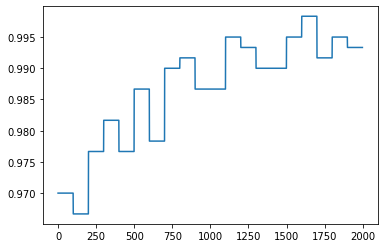

In [ ]:
plt.plot(run.records['valid_acc'])

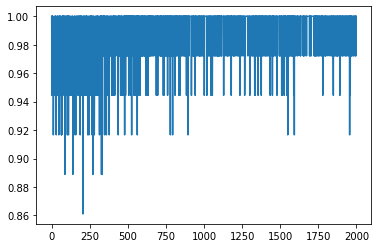

In [ ]:
plt.plot(run.records['train_acc'])

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
save_model(model, trainable_parameters, root + 'model-cat-slot-best-512-14-05.pkl')

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
tokenizer, model = get_model('bert-base-uncased', None)
model = add_adapter_layers(model, hidden_size=256)
load_model(model, root + 'model_intent.pkl')

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
tokenizer = tf.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
valid_dataset = D.IntentDataset(os.path.join(root, 'test'), tokenizer, max_len=120)
valid_data = valid_dataset.load_valid_data(batch_size=128)

In [ ]:
# Train only adapter layers
model = add_adapter_layers(model, hidden_size=256)
model.load_state_dict(pickle.load(open(os.path.join(root, 'model-cat-slot.pkl'), 'rb')), False)

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
def evaluate_valid_data(model, valid_data):
    model.eval()
    with T.no_grad():
        acc, count = 0, 0
        scores, intents, ids = [], [], []
        for i, batch in enumerate(valid_data):
            batch = D.IntentDataset.map_to_cuda(batch)
            scores_, _ = evaluate(model, batch)
            acc_, _, _ = metrics(scores_, batch.y)
            acc += (acc_*len(batch.y))
            count += len(batch.y)
            scores.append(scores_.cpu().numpy())
            intents += batch.intent
            ids += batch.id
            sys.stderr.write(f'\r{i+1}/{len(valid_data)} acc: {acc_}{"": <30}')
        acc = acc/count
        scores = np.concatenate(scores)
    model.train()
    return {'acc': acc, 'scores': scores.tolist(), 'labels': intents, 'ids': ids}

In [ ]:
results = evaluate_valid_data(model.cuda(), valid_data)

361/361 acc: 0.9722222222222222                              

In [ ]:
print(results['acc']) # Test

0.9691647150663544


In [ ]:
print(results['acc'])

0.9784484411550408


In [ ]:
import json
with open(root + 'valid-cat-value-scores-512-14-05.json', 'w') as f:
    json.dump(results, f)
#print(acc)

In [ ]:
print(acc)

0.8336131631967764


In [ ]:
import data as D
import json

schema = D.SlotDataset._extract_categorical_schema(json.load(open(root + 'train/schema.json')))
data = [result for dialog in json.load(open(root + 'train/dialogues.json')) 
for result in D.extract_labels(dialog)
        if any([r[0] in schema for r in result['labels']['new_values']])]

In [ ]:
data[300]

{'context': {'acts': {'Flights_3--OFFER--airlines--Delta Airlines',
   'Flights_3--OFFER--number_stops--1',
   'Flights_3--OFFER--outbound_departure_time--6:40 am',
   'Flights_3--OFFER--price--$335'},
  'dialog_hist_intents': {'Flights_3--SearchOnewayFlight'},
  'dialog_hist_services': {'Flights_3'},
  'prev_turn_intents': {'Flights_3--SearchOnewayFlight'},
  'prev_turn_services': {'Flights_3'}},
 'correct': False,
 'labels': {'intents': {'Flights_3--SearchRoundtripFlights'},
  'new_values': {('Flights_3--airlines', 'Delta Airlines', 'Delta Airlines'),
   ('Flights_3--flight_class', 'dontcare', 'Economy')},
  'req_slots': set(),
  'services': {'Flights_3'},
  'values': {'Flights_3--airlines--Delta Airlines',
   'Flights_3--departure_date--9th of March',
   'Flights_3--destination_city--New York',
   'Flights_3--flight_class--dontcare',
   'Flights_3--number_checked_bags--0',
   'Flights_3--origin_city--Vancouver'}},
 'system': 'How about Delta Airlines at $335 per passenger that takes

In [ ]:
[scores, slots] = json.load(open(root + 'valid-scores.json'))

In [ ]:
scores[315]

[3.5242717266082764,
 3.93858003616333,
 -2.261160135269165,
 -2.1685099601745605,
 -3.6290156841278076,
 -0.06675952672958374,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0,
 -100000000.0]

In [ ]:
import numpy as np
def attach_predictions(data, slots, scores, schema):
    i = 0
    for j, datum in enumerate(data):
        correct = True
        new_values = set()
        labels = datum['labels']['new_values']
        num_slots = len([label for label in labels if label[0] in schema])
        for _ in range(num_slots):
            slot, score = slots[i], scores[i]
            idx = int(np.argmax(score))
            prediction = list(schema[slot][-1])[idx]
            value = [label[1] for label in labels if label[0]==slot][0]
            correct = correct and (prediction == value)
            new_values.add((slot, value, prediction))
            i += 1
        datum['labels']['new_values'] = new_values
        datum['correct'] = correct

In [ ]:
attach_predictions(data, slots, scores, schema)

In [ ]:
import pickle
with open(root + 'train-slot-dialogues.json', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
np.mean([v[1]==v[2] for d in data for v in d['labels']['new_values']])

0.8770060441850771

In [ ]:
np.mean([d['correct'] for d in data])

0.8640337833819068

In [ ]:
incorrect = [d for d in data if not d['correct']]

In [ ]:
wrong_slots = [v[0].split('--')[1] for d in incorrect for v in d['labels']['new_values'] if v[1] != v[2]]

In [ ]:
incrrpect